## Parse and visualize Texas Hold 'Em tournament results

I created the HeuristicAI with the tight-aggressive and loose-aggressive play styles.  I was curious to see which play style would tend to win more often.  I ran 100 tournaments to pit them against each other.

Based on these tournament results I refined the play style and performed additional experiments.

In [1]:
# Imports
###############################################################################
# Standard system imports
import ctypes
from os import listdir
from os.path import isfile, join
# Related third party imports
import numpy as np
import pandas as pd
import seaborn as sns
# Local application/library specific imports

sns.set_style("darkgrid")

In [2]:
# Classes used to contain data
###############################################################################
class TournamentSummary(ctypes.Structure):
    """Creates a tournament_summary struct."""

    _fields_ = [('tournament_number', ctypes.c_int),
                ('random_seed', ctypes.c_int),
                ('initial_player_count', ctypes.c_int),
                ('player_ai_types', ctypes.POINTER(ctypes.c_int)),
                ('finishing_order', ctypes.POINTER(ctypes.c_int)),
                ('game_eliminated', ctypes.POINTER(ctypes.c_int)),
                ('num_games', ctypes.c_size_t)]


class PythonTournamentSummary:
    """Creates a tournament summary for parsing in Python."""

    def __init__(self, th, player_ai_types, finishing_order, game_eliminated):
        self.tournament_number = th.tournament_number
        self.random_seed = th.random_seed
        self.initial_player_count = th.initial_player_count
        self.player_ai_types = player_ai_types
        self.finishing_order = finishing_order
        self.game_eliminated = game_eliminated
        self.num_games = th.num_games



In [3]:
# Initialize and test C shared library
###############################################################################
# Location of C shared library
c_lib = ctypes.CDLL("../../Cpp/lib/lib_deepshark.so")
# %% Set data types of test C function's arguments and return value
add_ints = c_lib.add_ints
add_ints.argtypes = [ctypes.c_int, ctypes.c_int]
add_ints.restype = ctypes.c_int  # C function returns integer
# Test C function
result = add_ints(4, 5)
print(result)

9


In [4]:
# Initalize C function to get tournament results
###############################################################################
tourn_summary = c_lib.get_tournament_summary
tourn_summary.argtypes = [ctypes.POINTER(
    TournamentSummary), ctypes.POINTER(ctypes.c_char)]
tourn_summary.restype = None

In [5]:
# Function to parse and store tournament results
###############################################################################
def summarize_tournament_results(tourn_directory):
    tourn_files = [join(tourn_directory, f) for f in listdir(
        tourn_directory) if isfile(join(tourn_directory, f))]
    summary_list = list()
    for tourn in tourn_files:
        # Encode filename as a pointer to array of chars
        b_fn = tourn.encode("utf-8")  # create byte objects from the strings
        filename = ctypes.c_char_p(b_fn)
        # Instantiate struct to contain summary results
        th = TournamentSummary()
        th_ptr = ctypes.pointer(th)
        
        # Create NumPy arrays to store finishing order and game eliminated arrays
        player_ai_types_arr = np.zeros(10, dtype=np.intc)
        player_ai_types_ptr = player_ai_types_arr.ctypes.data_as(
            ctypes.POINTER(ctypes.c_int))
        th.player_ai_types = player_ai_types_ptr
        
        finishing_order_arr = np.zeros(10, dtype=np.intc)
        finishing_order_ptr = finishing_order_arr.ctypes.data_as(
            ctypes.POINTER(ctypes.c_int))
        th.finishing_order = finishing_order_ptr

        game_eliminated_arr = np.zeros(10, dtype=np.intc)
        game_eliminated_ptr = game_eliminated_arr.ctypes.data_as(
            ctypes.POINTER(ctypes.c_int))
        th.game_eliminated = game_eliminated_ptr
        
        # Pass pointer to struct and filename to C function
        tourn_summary(th_ptr, filename)
        # Transfer results to Python class and append to list
        pth = PythonTournamentSummary(th, player_ai_types_arr, finishing_order_arr, game_eliminated_arr)
        summary_list.append(pth)
    return summary_list

## TAG vs. LAG Tournament Results

Now, let's compare the performance of the tight-aggressive (TAG) player versus the loose-aggressive (LAG) player by simulating 100 ten-player tournaments.  Half the players in each tournament will be TAGs and the other half LAGs.  I simulated the tournaments and recorded the data to disk using the *generate_training_data.py* contained in `src/deepshark`.  For some reason running this code in a Jupyter notebook causes the Jupyter kernel to crash and restart, but it runs without issue from a Python script.

In [6]:
# Specify directory containing recorded tournaments and parse data
tourn_directory = "../../../recorded_games/2023-12-31/tag_lag/"  # Must update this field
summary_list = summarize_tournament_results(tourn_directory)

In [7]:
# Post-process tournament results
###############################################################################
lag_count = 0
tag_count = 0

lag_game_count = []
tag_game_count = []

for summ in summary_list:
    tourn_winner = summ.finishing_order[summ.initial_player_count-1]
    if summ.player_ai_types[tourn_winner] == 3:
        tag_count += 1
        tag_game_count.append(summ.game_eliminated[summ.initial_player_count-1])
    elif summ.player_ai_types[tourn_winner] == 4:
        lag_count += 1
        lag_game_count.append(summ.game_eliminated[summ.initial_player_count-1])

print(f"LAG tournament win count = {lag_count}")
print(f"TAG tournament win count = {tag_count}")

print(f"LAG average game count per tournament = {np.average(lag_game_count)}")
print(f"TAG average game count per tournament = {np.average(tag_game_count)}")

LAG tournament win count = 56
TAG tournament win count = 44
LAG average game count per tournament = 173.80357142857142
TAG average game count per tournament = 206.04545454545453


In [8]:
tag_finishing_order_arr = np.zeros(10)
lag_finishing_order_arr = np.zeros(10)

for summ in summary_list:
    for idx, plyr in enumerate(summ.finishing_order):
        if summ.player_ai_types[plyr] == 3: # TAG
            tag_finishing_order_arr[idx] += 1
        elif summ.player_ai_types[plyr] == 4: # LAG
            lag_finishing_order_arr[idx] += 1

cnt = summ.initial_player_count
tag_lag_df = pd.DataFrame(
    {
        "Result": [cnt-idx for idx in range(cnt)],
        "TAG": [x for x in tag_finishing_order_arr],
        "LAG": [x for x in lag_finishing_order_arr]
    }
)

tag_lag_df

,Result,TAG,LAG
0,10,22.0,78.0
1,9,32.0,68.0
2,8,34.0,66.0
3,7,41.0,59.0
4,6,49.0,51.0
5,5,60.0,40.0
6,4,69.0,31.0
7,3,79.0,21.0
8,2,70.0,30.0
9,1,44.0,56.0


<Axes: xlabel='Result'>

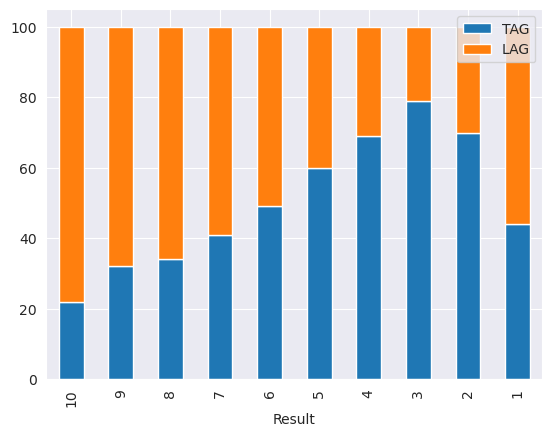

In [9]:
tag_lag_df.set_index("Result").plot(kind='bar', stacked=True)

### Tournament Results: TAG vs. LAG

An interesting result: the loose-aggressive players (LAG) were substantially more likely to be eliminated at the beginning of the tournament than the tight aggressive players (TAG), but overall the LAGs won the tournament more often than the TAGs.

The tight-aggressive TAGs only play the very best starting hands, while the loose-aggressive LAGs play a wider range of starting hands.  This means that the LAGs will often play weaker hands than the TAGs.  In the beginning of the tournament when the blinds are small and the table has many players, playing weakers hands is often punished because more players at the table means more hands being dealt - and thus a higher chance of a better hand being dealt to an opponent.  Meanwhile, playing tight and folding a lot of hands has little cost when the blinds are small.

As the tournament proceeds players will be eliminated from the table, and the blinds schedule will increase the blinds value to a more significant size.  Fewer players means that playing weaker hands has less risk, as it is less likely that an opponent will be dealt a better hand.  And playing too tight means folding hands that might be winners.  When the blinds were small at the beginning of the tournament the cost of playing too tight was negligible, but later in the tournament the blinds begin to eat away at players' chip stacks.  A too-tight player will then be punished by looser players "stealing" the blinds simply by being willing to play a wider range of hands than the tight players.  If a LAG player makes it to this late stage of the tournament it will have an advantage over the TAG - especially in heads-up play where the TAG will be losing at least a small blind worth of chips every time it folds.

If this is the case, then a significant improvement to the TAG's play style can made simply by having it switch to a wider list of starting hands when playing heads-up.  To do this, I simply added a new play style to the Heuristic AI that plays identical to the TAG up until there are three or fewer remaining players in the tournament, at which point it uses the LAG's list of starting hands to determine whether or not to fold.

## Modified Tight-Aggressive (MTAG) Tournament Performance

I called this new play style modified tight-aggressive or MTAG.  I decided to try three scenarios: 

1. MTAG vs. LAG: 100 ten-player tournaments, split equally 5 vs. 5

2. MTAG vs. TAG: 100 ten-player tournaments, split equally 5 vs. 5

3. MTAG vs. LAG vs. TAG: 300 ten-player tournaments, split 3 vs. 3 vs. 3 with the 10th player alternating between TAG, LAG, and MTAG

The third scenario will re-use the same 100 seeds for the 300 tournaments; meaning that each seed will be played three times with the 10th player of the tournament being either the TAG, LAG, or MTAG.


### MTAG vs. LAG

In [10]:
# Specify directory containing recorded tournaments and parse data
tourn_directory = "../../../recorded_games/2023-12-31/mtag_lag/"  # Must update this field
summary_list = summarize_tournament_results(tourn_directory)

In [11]:
# Post-process tournament results
###############################################################################
mtag_finishing_order_arr = np.zeros(10)
lag_finishing_order_arr = np.zeros(10)

for summ in summary_list:
    for idx, plyr in enumerate(summ.finishing_order):
        if summ.player_ai_types[plyr] == 5: # MTAG
            mtag_finishing_order_arr[idx] += 1
        elif summ.player_ai_types[plyr] == 4: # LAG
            lag_finishing_order_arr[idx] += 1

print(mtag_finishing_order_arr)
print(lag_finishing_order_arr)

[22. 32. 34. 41. 49. 60. 69. 78. 63. 52.]
[78. 68. 66. 59. 51. 40. 31. 22. 37. 48.]


In [12]:
cnt = summ.initial_player_count
mtag_vs_lag_df = pd.DataFrame(
    {
        "Result": [cnt-idx for idx in range(cnt)],
        "MTAG": [x for x in mtag_finishing_order_arr],
        "LAG": [x for x in lag_finishing_order_arr]
    }
)
mtag_vs_lag_df

,Result,MTAG,LAG
0,10,22.0,78.0
1,9,32.0,68.0
2,8,34.0,66.0
3,7,41.0,59.0
4,6,49.0,51.0
5,5,60.0,40.0
6,4,69.0,31.0
7,3,78.0,22.0
8,2,63.0,37.0
9,1,52.0,48.0


<Axes: xlabel='Result'>

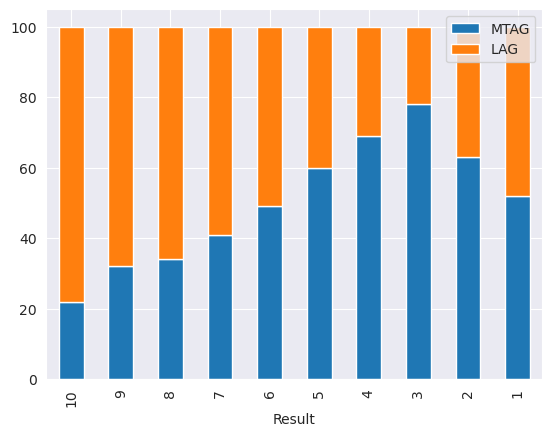

In [13]:
mtag_vs_lag_df.set_index("Result").plot(kind='bar', stacked=True)

### MTAG vs. LAG Results

The LAG places at the bottom ranking of the tournament much more frequently than the MTAG as expected, since the MTAG plays identically to the TAG at the beginning of the tournament.  However, the MTAG only has a very slight advantage in actually winning the tournament over the LAG (52 wins for the MTAG versus 48 wins for the LAG players).  This makes sense, as the MTAGs play identically to the LAGs once there are three or fewer players left in the tournament.  That being said, it's perhaps a bit surprising that the MTAG's early advantage didn't eliminate the LAG players often enough to garner a larger advantage in the final stages of the tournament.  It could be that playing loose against other loose players means that one LAG benefits from a winner-take-all outcome: the LAG players who are eliminated are largely eliminated by other LAG players and thus have large chip stacks going into the later stages of the tournament.  This may play an even bigger role in winning the tournament than the blind-stealing.


### MTAG vs. TAG

In [14]:
# Specify directory containing recorded tournaments and parse data
tourn_directory = "../../../recorded_games/2023-12-31/mtag_tag/"  # Must update this field
summary_list = summarize_tournament_results(tourn_directory)

In [15]:
# Post-process tournament results
###############################################################################
mtag_finishing_order_arr = np.zeros(10)
tag_finishing_order_arr = np.zeros(10)

for summ in summary_list:
    for idx, plyr in enumerate(summ.finishing_order):
        if summ.player_ai_types[plyr] == 5: # MTAG
            mtag_finishing_order_arr[idx] += 1
        elif summ.player_ai_types[plyr] == 3: # TAG
            tag_finishing_order_arr[idx] += 1

print(mtag_finishing_order_arr)
print(tag_finishing_order_arr)

[51. 41. 49. 50. 44. 55. 56. 43. 49. 62.]
[49. 59. 51. 50. 56. 45. 44. 57. 51. 38.]


In [16]:
cnt = summ.initial_player_count
mtag_tag_df = pd.DataFrame(
    {
        "Result": [cnt-idx for idx in range(cnt)],
        "MTAG": [x for x in mtag_finishing_order_arr],
        "TAG": [x for x in tag_finishing_order_arr]
    }
)
mtag_tag_df

,Result,MTAG,TAG
0,10,51.0,49.0
1,9,41.0,59.0
2,8,49.0,51.0
3,7,50.0,50.0
4,6,44.0,56.0
5,5,55.0,45.0
6,4,56.0,44.0
7,3,43.0,57.0
8,2,49.0,51.0
9,1,62.0,38.0


<Axes: xlabel='Result'>

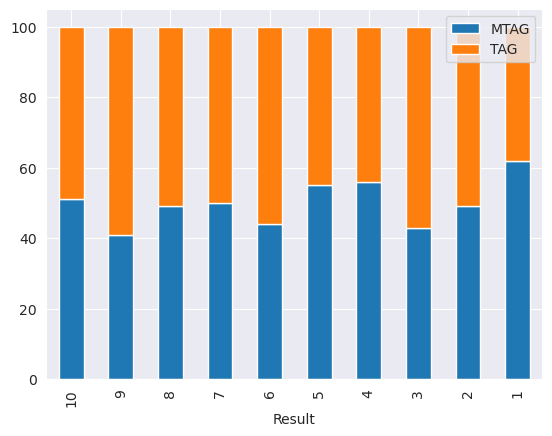

In [17]:
mtag_tag_df.set_index("Result").plot(kind='bar', stacked=True)

### MTAG vs. TAG Results

The results in the early stages of the tournament are very even between the TAG and MTAG as expected, since their play style is identical.  The TAG has more third and second place finishes than the MTAG, but the MTAG has significantly more tournament victories than the TAG (62 for the MTAG versus 38 for the TAG).  This seems to indicate that playing looser in the final stages of the tournament does indeed provide an advantage over too-tight players.

So far the MTAG play style does seem to be the best of both worlds compared to its two predecessors individually.  But what happens when all three play styles are present in the same tournament?

### MTAG vs. LAG vs. TAG

In [18]:
# Specify directory containing recorded tournaments and parse data
tourn_directory = "../../../recorded_games/2023-12-31/mtag_lag_tag/"  # Must update this field
summary_list = summarize_tournament_results(tourn_directory)

In [19]:
# Post-process tournament results
###############################################################################
lag_count = 0
tag_count = 0
mtag_count = 0

lag_game_count = []
tag_game_count = []
mtag_game_count = []

for summ in summary_list:
    tourn_winner = summ.finishing_order[summ.initial_player_count - 1]
    if summ.player_ai_types[tourn_winner] == 3: # TAG
        tag_count += 1
        tag_game_count.append(summ.game_eliminated[summ.initial_player_count-1])
    elif summ.player_ai_types[tourn_winner] == 4: # LAG
        lag_count += 1
        lag_game_count.append(summ.game_eliminated[summ.initial_player_count-1])
    elif summ.player_ai_types[tourn_winner] == 5: # MTAG
        mtag_count += 1
        mtag_game_count.append(summ.game_eliminated[summ.initial_player_count-1])
    else:
        tag_count += 1
        tag_game_count.append(summ.game_eliminated[summ.initial_player_count-1])        

print(f"LAG tournament win count = {lag_count}")
print(f"TAG tournament win count = {tag_count}")
print(f"MTAG tournament win count = {mtag_count}")

print(f"LAG average game count per tournament = {np.average(lag_game_count)}")
print(f"TAG average game count per tournament = {np.average(tag_game_count)}")
print(f"MTAG average game count per tournament = {np.average(mtag_game_count)}")

LAG tournament win count = 106
TAG tournament win count = 88
MTAG tournament win count = 106
LAG average game count per tournament = 173.21698113207546
TAG average game count per tournament = 211.4090909090909
MTAG average game count per tournament = 187.50943396226415


In [20]:
tag_finishing_order_arr = np.zeros(10)
lag_finishing_order_arr = np.zeros(10)
mtag_finishing_order_arr = np.zeros(10)

for summ in summary_list:
    for idx, plyr in enumerate(summ.finishing_order):
        if summ.player_ai_types[plyr] == 3: # TAG
            tag_finishing_order_arr[idx] += 1
        elif summ.player_ai_types[plyr] == 4: # LAG
            lag_finishing_order_arr[idx] += 1
        elif summ.player_ai_types[plyr] == 5: # MTAG
            mtag_finishing_order_arr[idx] += 1

print(tag_finishing_order_arr)
print(lag_finishing_order_arr)
print(mtag_finishing_order_arr)

[ 39.  74.  84.  81. 117. 117. 123. 139. 138.  88.]
[207. 155. 137. 123.  60.  59.  48.  39.  66. 106.]
[ 54.  71.  79.  96. 123. 124. 129. 122.  96. 106.]


In [21]:
cnt = summ.initial_player_count
mtag_lag_tag_df = pd.DataFrame(
    {
        "Result": [cnt-idx for idx in range(cnt)],
        "TAG": [x for x in tag_finishing_order_arr],
        "LAG": [x for x in lag_finishing_order_arr],
        "MTAG": [x for x in mtag_finishing_order_arr],
    }
)
mtag_lag_tag_df

,Result,TAG,LAG,MTAG
0,10,39.0,207.0,54.0
1,9,74.0,155.0,71.0
2,8,84.0,137.0,79.0
3,7,81.0,123.0,96.0
4,6,117.0,60.0,123.0
5,5,117.0,59.0,124.0
6,4,123.0,48.0,129.0
7,3,139.0,39.0,122.0
8,2,138.0,66.0,96.0
9,1,88.0,106.0,106.0


<Axes: xlabel='Result'>

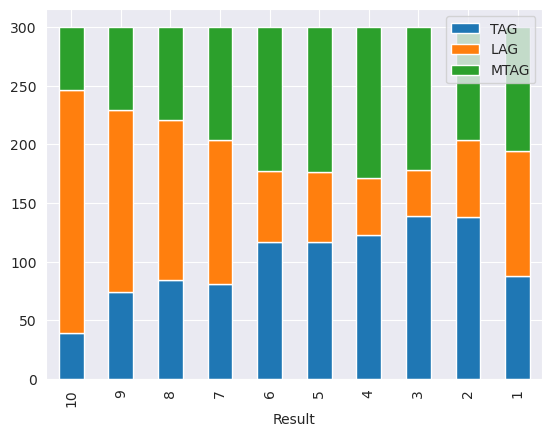

In [22]:
mtag_lag_tag_df.set_index("Result").plot(kind='bar', stacked=True)

### MTAG vs. LAG vs. TAG Results

The pattern seems to hold with all three play styles in one tournament.  The LAG players still tend to be eliminated early in the tournament, and yet the LAGs won exactly as many tournaments as the MTAGs.  The TAGs and MTAGs had very similar early-tournament performance, but the MTAG took home more tournament wins.

Overall, the MTAG appears to be a good compromise between the too-tight TAGs and the too-loose LAGs.

### MTAG vs. Random Players

Just for fun, I pit one MTAG player against 9 completely random players.  I was curious to see how many tournaments the MTAG would win.

In [23]:
# Specify directory containing recorded tournaments and parse data
tourn_directory = "../../../recorded_games/2024-01-02/random/"  # Must update this field
summary_list = summarize_tournament_results(tourn_directory)

In [24]:
# Post-process tournament results
###############################################################################
random_count = 0
mtag_count = 0

random_game_count = []
mtag_game_count = []

for summ in summary_list:
    tourn_winner = summ.finishing_order[summ.initial_player_count-1]
    if summ.player_ai_types[tourn_winner] == 5:
        mtag_count += 1
        mtag_game_count.append(summ.game_eliminated[summ.initial_player_count-1])
    elif summ.player_ai_types[tourn_winner] == 0:
        random_count += 1
        random_game_count.append(summ.game_eliminated[summ.initial_player_count-1])

print(f"Random tournament win count = {random_count}")
print(f"MTAG tournament win count = {mtag_count}")

print(f"Random average game count per tournament = {np.average(random_game_count)}")
print(f"MTAG average game count per tournament = {np.average(mtag_game_count)}")

Random tournament win count = 89
MTAG tournament win count = 11
Random average game count per tournament = 38.146067415730336
MTAG average game count per tournament = 62.90909090909091


In [27]:
mtag_finishing_order_arr = np.zeros(10)
random_finishing_order_arr = np.zeros(10)

for summ in summary_list:
    for idx, plyr in enumerate(summ.finishing_order):
        if summ.player_ai_types[plyr] == 5: # MTAG
            mtag_finishing_order_arr[idx] += 1
        elif summ.player_ai_types[plyr] == 0: # Random
            random_finishing_order_arr[idx] += 1

cnt = summ.initial_player_count
mtag_random_df = pd.DataFrame(
    {
        "Result": [cnt-idx for idx in range(cnt)],
        "MTAG": [x for x in mtag_finishing_order_arr],
        "Random": [x for x in random_finishing_order_arr]
    }
)

mtag_random_df

,Result,MTAG,Random
0,10,0.0,100.0
1,9,0.0,100.0
2,8,0.0,100.0
3,7,0.0,100.0
4,6,0.0,100.0
5,5,1.0,99.0
6,4,1.0,99.0
7,3,1.0,99.0
8,2,86.0,14.0
9,1,11.0,89.0


<Axes: xlabel='Result'>

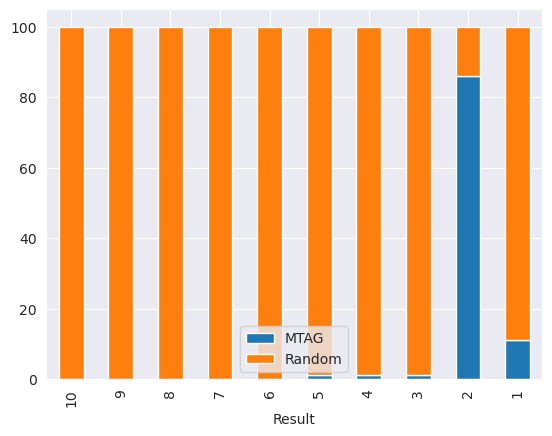

In [28]:
mtag_random_df.set_index("Result").plot(kind='bar', stacked=True)

### MTAG vs. Random Players Results

At first the results seemed shocking - 1 MTAG versus 9 random players and the MTAG only won 11/100 games.  That's a roughly 10% win rate, which is about the number of games it would be expected to win if it also was a random player.  Once the full tournament results are plotted the picture becomes more clear.  The MTAG player almost always made it to the tournament finals (97 out of 100 games) but got second place the vast majority of the time.  Without inspecting the games in detail, I'd imagine this is because the random players fed each other their chips by frequently betting or going all-in with terrible hands.  The average number of games for a tournament won by the random player was only 38 games.  Most likely there was a cascade of all-ins followed by player eliminations, and the MTAG player ended up in the finals against a random player with a chip stack 9 times larger than its own.  This is an extreme disadvantage, and one in which I would imagine that even a professional player would often lose to a beginner.